Group 5: Sam Young, Raveel Tejani

# Linear regression: regularization and logistic regression

Today we will look at two very useful extensions of linear regression algorithms.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_predict, KFold, train_test_split
from sklearn.metrics import accuracy_score

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 100

## Step 1: Generate Data

First let's generate a dataset with more than one feature variable to explore algorithms that can be used to reduce overfitting.

In [2]:
np.random.seed(16) #set seed for reproducibility purposes

x1 = np.arange(100)
x2 = np.linspace(0,1,100)
x3 = np.logspace(2,3,num=100) 
ypb = 3*x1 + 0.5*x2 + 15*x3 + 3 + 5*(np.random.poisson(3*x1 + 0.5*x2 + 15*x3,100)-(3*x1 + 0.5*x2 + 15*x3)) 
                                                    #generate some data with scatter following Poisson distribution 
                                                    #with exp value = y from linear model, centered around 0
        
xb = np.vstack((x1,x2,x3)).T # this gives us three features

Now we add correlated features with a polynomial transformation:

In [3]:
poly = PolynomialFeatures(2, include_bias=False)
new_xb = poly.fit_transform(xb) # this dives us 9 features total
new_xb.shape

(100, 9)

## Step 2:  Ridge regression

Set up Ridge regression, and determine cross-validated scores for different values of alpha that are logarithmically spaced in the rage between $10^{-6}$ and $10^6$, then find the best alpha that optimizes the test score. For this to be meaningful, the data should be standardized, so please set up a pipeline with Ridge() and the StandardScaler() you used earlier. Make a plot of mean test scores versus alpha. Which scale is more appropriate, linear or logarithmic?

 - logarithmic scale is better

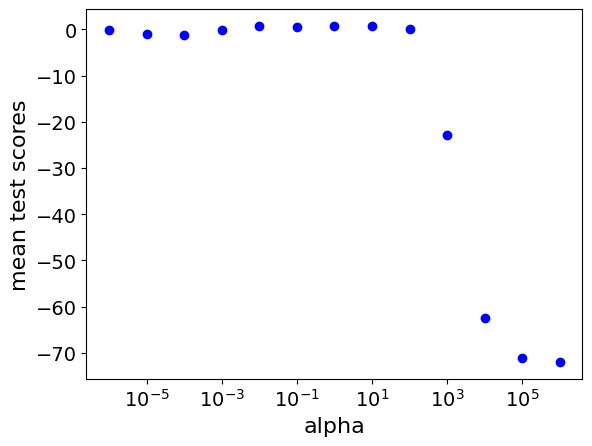

Best alpha: 10.0


In [4]:
alphas = np.logspace(-6,6, 13)
test_scores = []
test_scores_std = []
for alpha in alphas:
    model    = Ridge(alpha = alpha)
    scaler   = StandardScaler()
    pipeline = make_pipeline(scaler, model)
    #pipleline.fit(xb, ypb)
    metrics = cross_validate(pipeline, new_xb, ypb,  cv = 5)
    test_scores.append(metrics['test_score'].mean())
    test_scores_std.append(metrics['test_score'].std())
    
plt.semilogx(alphas, test_scores, 'bo')
plt.xlabel('alpha')
plt.ylabel("mean test scores")
plt.show()

best_alpha = alphas[np.argmax(test_scores)]
print("Best alpha: {}".format(best_alpha))

There is a built-in routine for this hyperparameter optimization scan called RidgeCV. Try it out, do you get the same answer as before?

 - answer is not the same as before

In [5]:
ridge_cv = RidgeCV(alphas=alphas)#, cv = 5)
ridge_cv.fit(new_xb, ypb)

best_alpha = ridge_cv.alpha_
print("Best alpha, model: RidgeCV =  {}".format(best_alpha))

Best alpha, model: RidgeCV =  0.1


The coefficients of the linear model are strongly affected by regularization. Pick one or two of the features and plot the absolute value of the coefficient for the range of alphas used above in the search scan.  Which scale makes most sense for this plot, linear or logarithmic?

 - log scale is better

Remember that the data must be standardized for this comparison to make sense, so either use a pipeline or fit_transform your data first to standard form using StandardScaler.

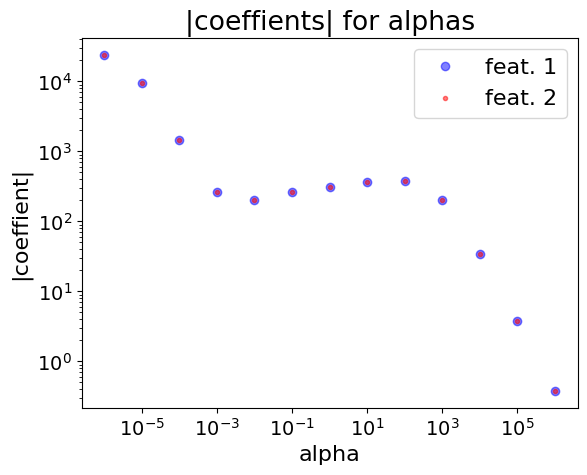

In [6]:
xb_scaled = scaler.fit_transform(new_xb)

coefficients_0 = []
coefficients_1 = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(xb_scaled, ypb)
    coefficients_0.append(np.abs(model.coef_[0]))
    coefficients_1.append(np.abs(model.coef_[1]))

plt.loglog(alphas, coefficients_0, 'bo', label='feat. 1', alpha = 0.5)
plt.loglog(alphas, coefficients_1, 'r.', label='feat. 2', alpha = 0.5)
#plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('|coeffient|')
plt.title('|coeffients| for alphas')
plt.legend()
plt.show()

## Step 3: Lasso regression

Repeat the items of step 2 for Lasso regression, now for a smaller range of alpha values $10^{-1}$ and $10^4$. Also, to avoid numerical instabilities, in Lasso set the parameters *max_iter = 10000000, tol = 1e-6*

Best alpha: 0.3162


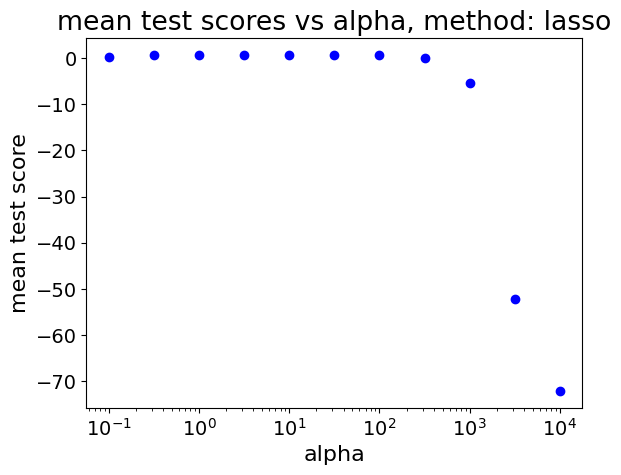

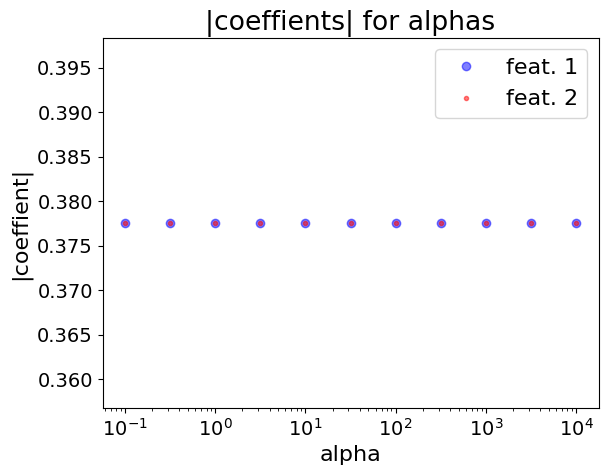

In [7]:
alphas = np.logspace(-1, 4, 11)

test_scores = []
for alpha in alphas:
    pipeline = make_pipeline(StandardScaler(), Lasso(max_iter=10000000, tol=1e-6, alpha = alpha))
    metrics = cross_validate(pipeline, new_xb, ypb, cv=5)
    test_scores.append(metrics['test_score'].mean())
    
best_alpha = alphas[np.argmax(test_scores)]
print("Best alpha: {:.4f}".format(best_alpha))
plt.semilogx(alphas, test_scores, 'bo')
plt.xlabel('alpha')
plt.ylabel('mean test score')
plt.title('mean test scores vs alpha, method: lasso')
plt.show()

coefficients_0 = []
coefficients_1 = []
for alpha in alphas:
    pipeline = make_pipeline(StandardScaler(), Lasso(max_iter=10000000, tol=1e-6, alpha = alpha))
    pipeline.fit(new_xb, ypb)
    coefficients_0.append(np.abs(model.coef_[0]))
    coefficients_1.append(np.abs(model.coef_[1]))

plt.plot(alphas, coefficients_0, 'bo', label='feat. 1', alpha = 0.5)
plt.plot(alphas, coefficients_1, 'r.', label='feat. 2', alpha = 0.5)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('|coeffient|')
plt.title('|coeffients| for alphas')
plt.legend()
plt.show()

## Step 4: Logistic regression

Logistic regression can be used as a classifier on categorical data. To check it out, let's revisit the habitable planet data set from Lab 3, *HPLearningSet.csv*.

Load the data set and create a feature matix X with the first two features, mass and period. Fit sklearn's *LogisticRegression(random_state=1,penalty=None)*, print the prediction and the accuracy for this model.

In [8]:
data = pd.read_csv('HPLearningSet.csv')
features = data[['S_MASS', 'P_PERIOD']]
labels = data['P_HABITABLE']

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=1)
log_reg = LogisticRegression(random_state=1, penalty=None)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("predictions: {}".format(y_pred))
print("accuracy: {}".format(accuracy))

predictions: [0 1 1 0 1]
accuracy: 0.6


Now we will try to create our own implementation of logistic regression, using gradient descent. The relevant loss function is the negative of eq. (5.25). First, you need to compute analytically the gradient of the loss function wrt. $\beta$. This replace the MSE loss in your gradient descent code from lab 10. To facilitate the code, it is useful to also define the sigmoid function eq. (5.21) that returns the probabilities that you will need in the gradient. You could then define another function *predict* that takes the probabilities and returns either 0 or 1, depending on whether the probabilities are less than or greater than 0.5.

We can set *np.random.seed(1)* to intialize a suitable solution vector. Remember that a column of ones must be added to the feature matrix X just as before to take care of the offset. Try starting with a learning rate of $\eta=0.0001$. 

Print the accuracy and predictions of your own logistic regression and compare to sklearn's answer. You might need a quite large number of iterations (up to $10^6$) to reach the same predictions.

In [9]:
np.random.seed(1)

lr=0.0001
num_iterations=int(1e6)


def logistic_GD(X, y, lr, num_iterations):
    np.random.seed(1)
    instances = X.shape[0]
    X = np.c_[np.ones((instances, 1)), X] 
    beta = np.zeros(3)

    for i in range(num_iterations):
        # gradient
        sig = sigmoid(np.dot(X, beta))
        grad = np.dot(X.T, (sig - y)) / instances
        
        #beta correction
        beta = beta - (lr * grad)  
    return beta

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, beta):
    probabilities = sigmoid(np.dot(X, beta))
    predictions = np.where(probabilities >= 0.5, 1, 0)
    return predictions


beta = logistic_GD(X_train, y_train,0.0001, num_iterations)
X_test_one = np.c_[np.ones(len(X_test)).reshape(-1,1), X_test]
predictions = predict(X_test_one, beta)
accuracy = accuracy_score(y_test, predictions)

print("predictions: {}".format(predictions))
print("accuracy: {}".format(accuracy))

predictions: [0 1 1 0 1]
accuracy: 0.6
